<div align="center">

#### Uczenie maszynowe | Inżynieria i Analiza Danych
# Uczenie nadzorowane - klasyfikacja 
### Mateusz Bugdol  
### Nr indeksu: 419719  
### Grupa ćwiczeniowa: 1 
 
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

1. Wczytaj zbiór danych

In [2]:
df = pd.read_csv('../data/wine.data', header=None)
cols = [
    "Class",
    "Alcohol",
    "Malic_acid",
    "Ash",
    "Alcalinity_of_ash",
    "Magnesium",
    "Total_phenols",
    "Flavanoids",
    "Nonflavanoid_phenols",
    "Proanthocyanins",
    "Color_intensity",
    "Hue",
    "OD280/OD315_of_diluted_wines",
    "Proline"
]

df.columns = cols
df.head()

,Class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


2. Podziel zbiór danych na zbiór treningowy i testowy, dodatkowo w zmiennej X zapisz macierz zmiennych niezależnych, w zmiennej Y zapisz wektor zawierający informacje o tym jaki jest to typ wina (1, 2, 3).

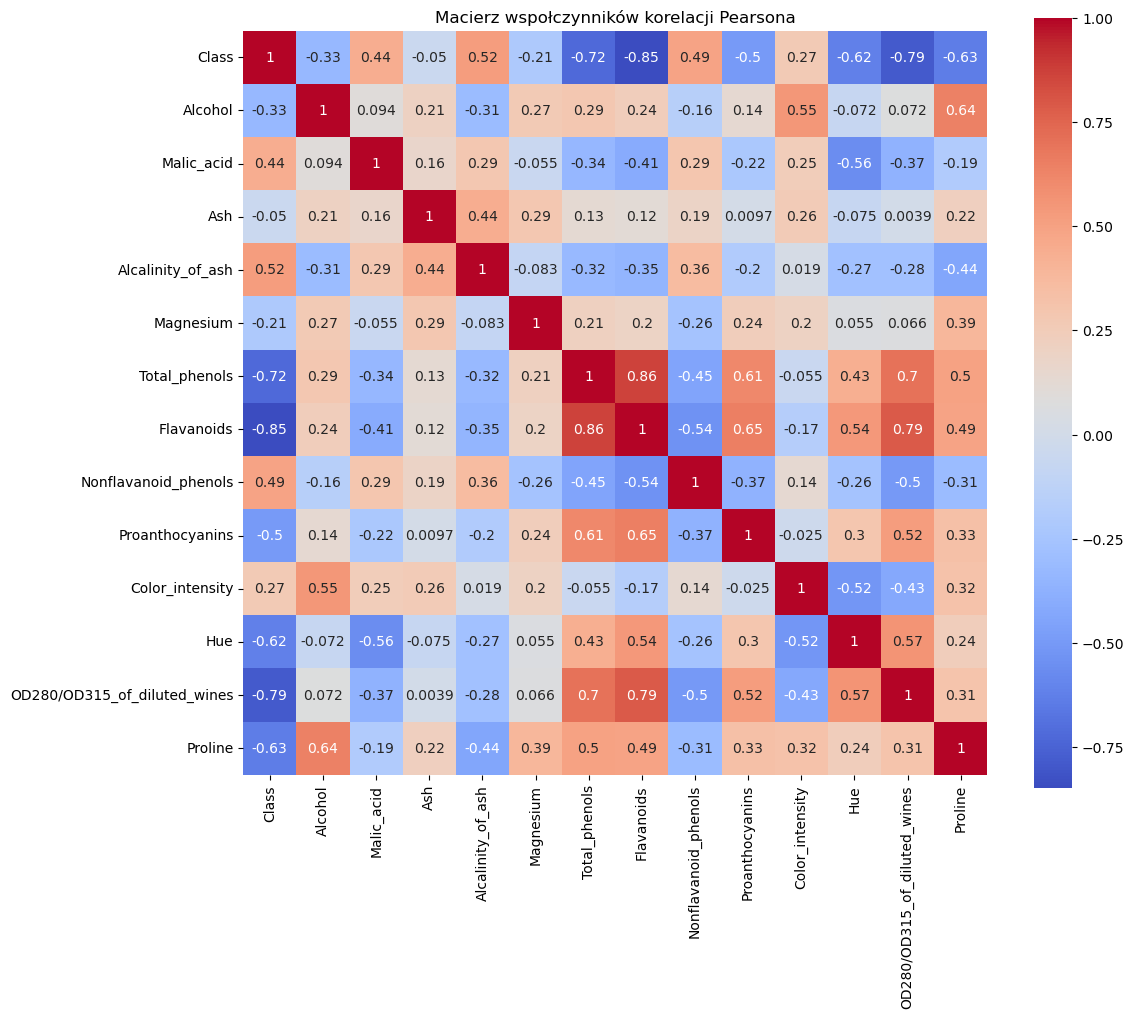

In [3]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(method='pearson'), annot=True, cmap='coolwarm', square=True)
plt.title("Macierz wspołczynników korelacji Pearsona")
plt.show()

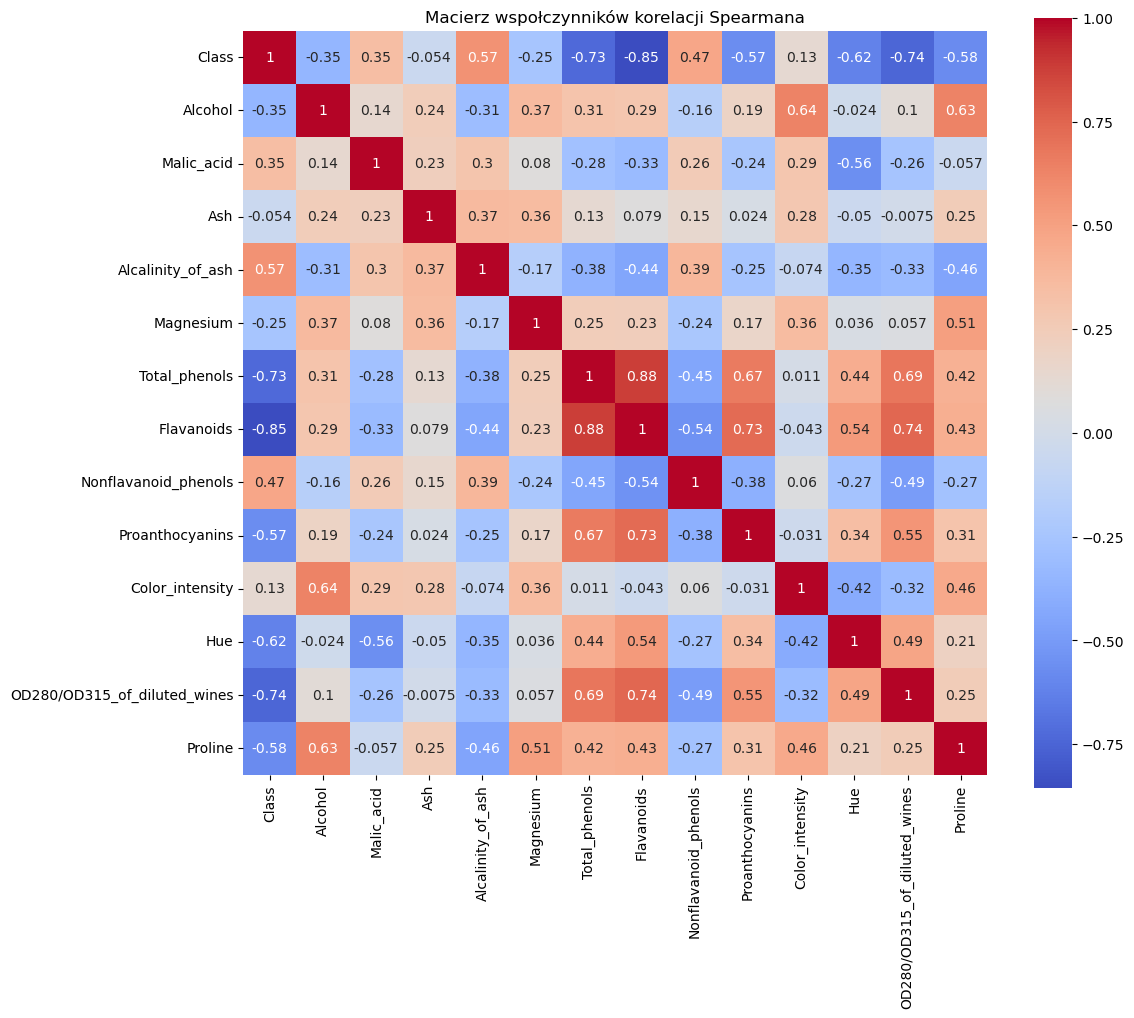

In [4]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(method='spearman'), annot=True, cmap='coolwarm', square=True)
plt.title("Macierz wspołczynników korelacji Spearmana")
plt.show()

Patrząc na obie macierze korelacji współczynnikoów Pearsona i Spearmana można dojść do wniosku, że jedynymi zmiennymi niezależnymi mogącymi pomóc sklasyfikować wina są:

- Flavanoids,
- Hue,
- Color_intensity,
- Proline
- Alcanity_of_ash.

In [5]:
from sklearn.model_selection import train_test_split

X_names = [
    "Flavanoids", 
    "Hue",
    "Color_intensity",
    "Proline",
    "Alcalinity_of_ash"
]

X = df[X_names]
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3127, stratify=y)

print("Ilości próbek w zbiorach:")
print(f"Train set: {X_train.shape[0]} próbek")
print(f"Test set: {X_test.shape[0]} próbek")

Ilości próbek w zbiorach:
Train set: 142 próbek
Test set: 36 próbek


3. Dokonaj normalizacji danych. Skomentuj po co jest ten krok i jak może on wpływać na działania algorytmów z kolejnego punktu.

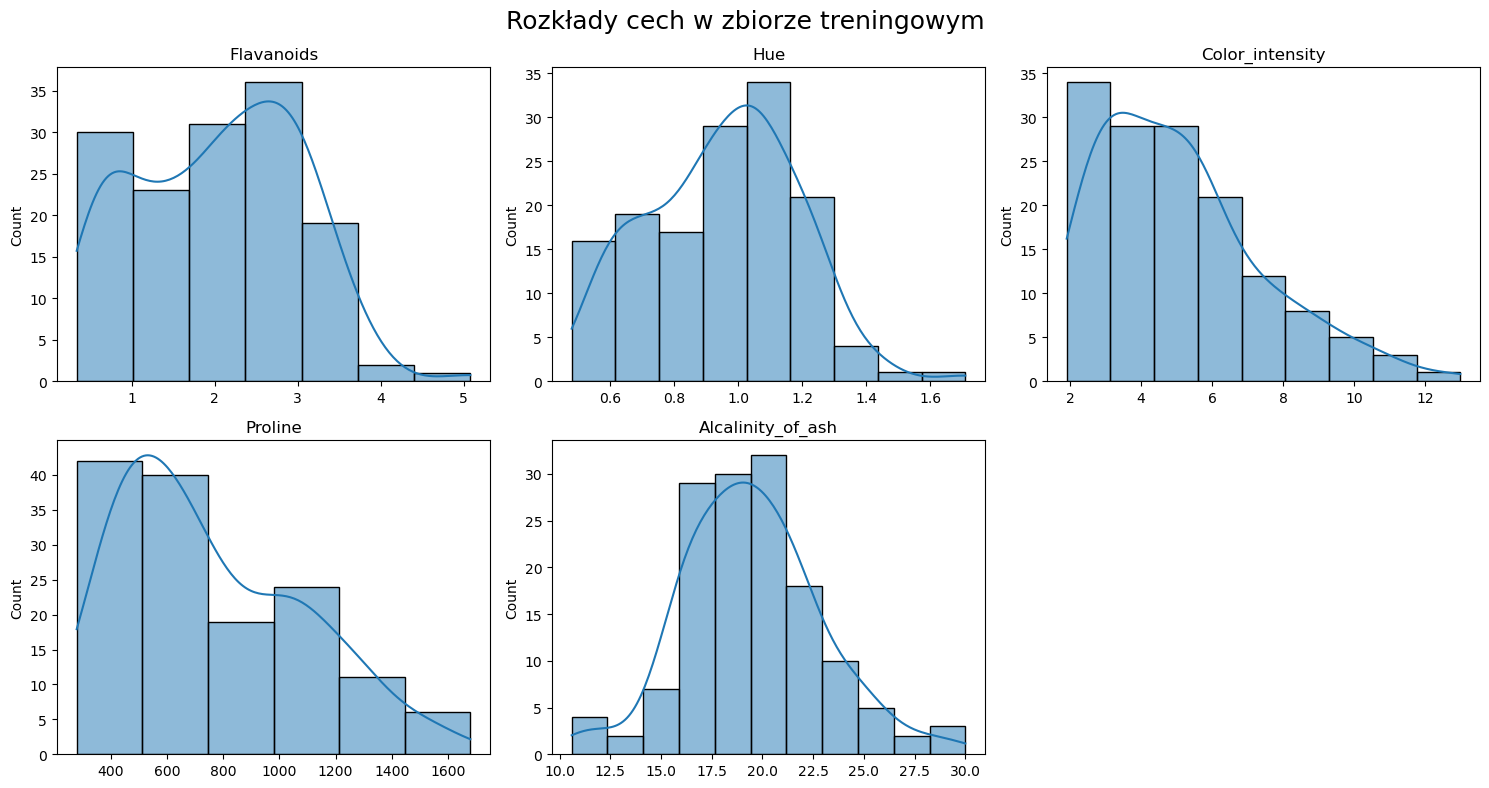

In [6]:
n_cols = 3
n_rows = int((len(X_train.columns) + n_cols - 1) / n_cols)

plt.figure(figsize=(15, 4 * n_rows))

for i, col in enumerate(X_train.columns, 1):
    x = X_train[col].values

    q75, q25 = np.percentile(x, [75, 25])
    iqr = q75 - q25
    bin_width = 2 * iqr / np.cbrt(len(x))
    bins = int((x.max() - x.min()) / bin_width)

    plt.subplot(n_rows, n_cols, i)
    sns.histplot(
        x,
        bins=bins,
        kde=True
    )
    plt.title(col)

plt.suptitle("Rozkłady cech w zbiorze treningowym", fontsize=18)
plt.tight_layout()
plt.show()

Patrząc na rozkłady zmiennych niezależnych, można zauważyć, że zmienne Color_intensity oraz Proline mają rozkład prawoskośny. W związku z tym warto rozważyć ich przekształcenie logarytmiczne, aby zbliżyć rozkład do normalnego i zmniejszyć wpływ wartości odstających.

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

log_features = [
    "Color_intensity",
    "Proline"
]

scale_features = [
    "Flavanoids",
    "Hue",
    "Alcalinity_of_ash"
]

preprocessor = ColumnTransformer(
    transformers=[
        ('log', Pipeline([
            ('log', FunctionTransformer(np.log, feature_names_out='one-to-one')),
            ('scaler', StandardScaler())
        ]), log_features),

        ('scale', Pipeline([
            ('scaler', StandardScaler())
        ]), scale_features)
    ]
)

4. Wykonaj trening dla algorytmów KNeighborsClassifier oraz RandomForestClassifier (biblioteka scikit-learn)

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5, metric='euclidean'))
])

random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=3127))
])

In [9]:
knn_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log', ...), ('scale', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
random_forest_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log', ...), ('scale', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


5. Wykonaj klasyfikację.

In [11]:
y_train_pred_knn = knn_pipeline.predict(X_train)
y_test_pred_knn = knn_pipeline.predict(X_test)

y_train_pred_rf = random_forest_pipeline.predict(X_train)
y_test_pred_rf = random_forest_pipeline.predict(X_test)

6. Zapoznaj się z metrykami dostępnymi w [scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics). Opisz o czym mówią i w jakim kontekście używamy: accuracy, precision, recall and F-measures, confusion matrix oraz napisz czym jest classification report.

### Confusion Matrix (Macierz pomyłek)

Confusion matrix (macierz pomyłek) to tabelaryczne zestawienie wyników klasyfikacji, pokazujące liczbę poprawnych i błędnych predykcji modelu w podziale na rzeczywiste oraz przewidywane klasy. Umożliwia szczegółową analizę rodzaju błędów popełnianych przez klasyfikator.

W przypadku klasyfikacji binarnej macierz pomyłek zawiera cztery elementy:
- TP (True Positives) – liczba obiektów pozytywnych poprawnie zaklasyfikowanych jako pozytywne,
- TN (True Negatives) – liczba obiektów negatywnych poprawnie zaklasyfikowanych jako negatywne,
- FP (False Positives) – liczba obiektów negatywnych błędnie zaklasyfikowanych jako pozytywne,
- FN (False Negatives) – liczba obiektów pozytywnych błędnie zaklasyfikowanych jako negatywne.

Macierz pomyłek stanowi podstawę do obliczania metryk klasyfikacji, takich jak: accuracy, precision, recall (sensitivity), specificity oraz F1-score.

### Accuracy

Odsetek wszystkich predykcji, które zostały sklasyfikowane poprawnie.

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

### Sensitivity (Recall)

Odsetek rzeczywistych przykładów pozytywnych, które zostały poprawnie sklasyfikowane jako pozytywne.

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

### Specificity

Odsetek rzeczywistych przykładów negatywnych, które zostały poprawnie sklasyfikowane jako negatywne.

$$
\text{Specificity} = \frac{TN}{TN + FP}
$$

### Precision

Odsetek poprawnych predykcji pozytywnych wśród wszystkich przypadków zaklasyfikowanych jako pozytywne.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

### F1-score

Średnia harmoniczna precision i recall. Jest przydatna w sytuacjach, gdy chcemy zrównoważyć znaczenie obu tych metryk.

$$
\text{F1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

### Classification Report

Classification report to zestawienie metryk jakości klasyfikacji (precision, recall, F1-score i support) dla każdej klasy osobno. Pozwala na ocenę skuteczności modelu z uwzględnieniem nierównomiernie reprezentowanych klas. Jest szczególnie przydatny w analizie problemów z niezbalansowanymi danymi, gdzie accuracy może nie oddawać rzeczywistej jakości modelu.

7. W nawiązaniu do metryk omawianych na wykładzie i tych analizowanych w punkcie 6. dokonaj analizy predykcji poszczególnych modeli. 

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print("KNN Classifier - Train Set")
print(classification_report(y_train, y_train_pred_knn))
knntrain = confusion_matrix(y_train, y_train_pred_knn)
print("Confusion Matrix:\n", knntrain)

KNN Classifier - Train Set
              precision    recall  f1-score   support

           1       0.96      1.00      0.98        47
           2       1.00      0.96      0.98        57
           3       1.00      1.00      1.00        38

    accuracy                           0.99       142
   macro avg       0.99      0.99      0.99       142
weighted avg       0.99      0.99      0.99       142

Confusion Matrix:
 [[47  0  0]
 [ 2 55  0]
 [ 0  0 38]]


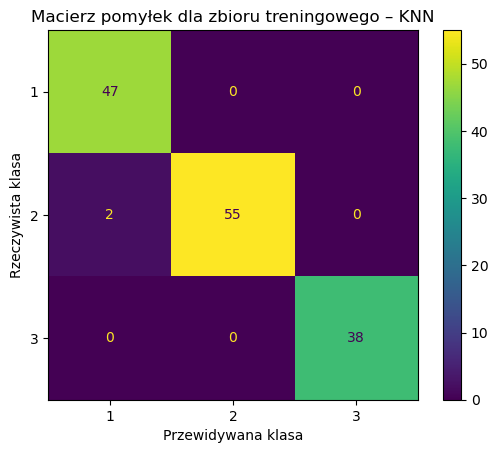

In [13]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=knntrain,
    display_labels=knn_pipeline.classes_
)
disp.plot()

plt.title("Macierz pomyłek dla zbioru treningowego – KNN")
plt.xlabel("Przewidywana klasa")
plt.ylabel("Rzeczywista klasa")
plt.show()

In [14]:
print("\nKNN Classifier - Test Set")
print(classification_report(y_test, y_test_pred_knn))
knntest = confusion_matrix(y_test, y_test_pred_knn)
print("Confusion Matrix:\n", knntest)


KNN Classifier - Test Set
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36

Confusion Matrix:
 [[12  0  0]
 [ 0 14  0]
 [ 0  0 10]]


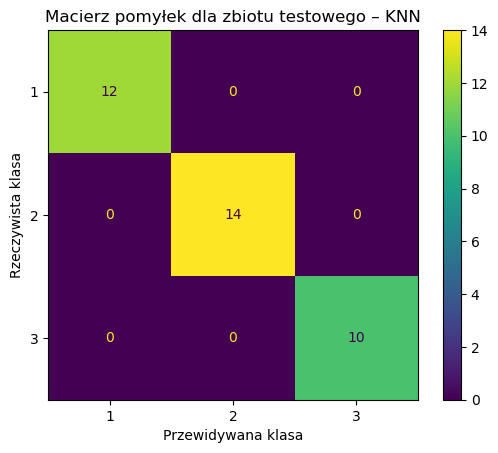

In [15]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=knntest,
    display_labels=knn_pipeline.classes_
)
disp.plot()

plt.title("Macierz pomyłek dla zbiotu testowego – KNN")
plt.xlabel("Przewidywana klasa")
plt.ylabel("Rzeczywista klasa")
plt.show()

In [16]:
print("Random Forest Classifier - Train Set")
print(classification_report(y_train, y_train_pred_rf))
rftrain = confusion_matrix(y_train, y_train_pred_rf)
print("Confusion Matrix:\n", rftrain)

Random Forest Classifier - Train Set
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        47
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        38

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142

Confusion Matrix:
 [[47  0  0]
 [ 0 57  0]
 [ 0  0 38]]


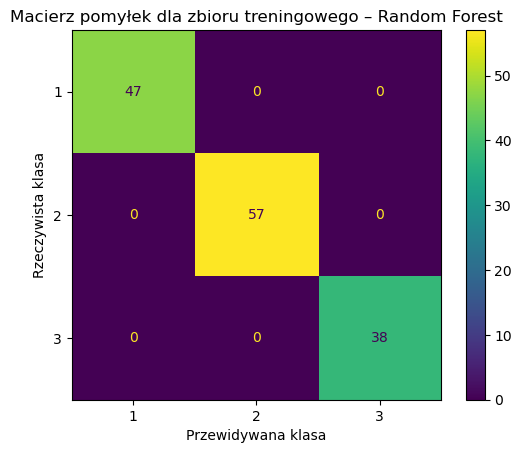

In [17]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=rftrain,
    display_labels=random_forest_pipeline.classes_
)
disp.plot()

plt.title("Macierz pomyłek dla zbioru treningowego – Random Forest")
plt.xlabel("Przewidywana klasa")
plt.ylabel("Rzeczywista klasa")
plt.show()

In [18]:
print("\nRandom Forest Classifier - Test Set")
print(classification_report(y_test, y_test_pred_rf))
rftest = confusion_matrix(y_test, y_test_pred_rf)
print("Confusion Matrix:\n", rftest)


Random Forest Classifier - Test Set
              precision    recall  f1-score   support

           1       1.00      0.92      0.96        12
           2       0.93      1.00      0.97        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36

Confusion Matrix:
 [[11  1  0]
 [ 0 14  0]
 [ 0  0 10]]


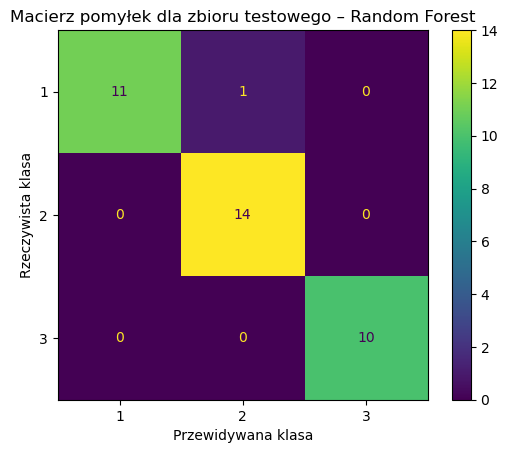

In [19]:
disp = ConfusionMatrixDisplay(
    confusion_matrix=rftest,
    display_labels=random_forest_pipeline.classes_
)
disp.plot()

plt.title("Macierz pomyłek dla zbioru testowego – Random Forest")
plt.xlabel("Przewidywana klasa")
plt.ylabel("Rzeczywista klasa")
plt.show()

8. Napisz interpretację wynikającą z analizy metryk - w szczególności z czego może wynikać różnica w działaniu tych dwóch modeli.

Na podstawie metryk widać, że model KNN osiągnął idealne wyniki na zbiorze testowym (accuracy, precision, recall i F1-score równe 1.00), co oznacza brak błędnych klasyfikacji. Sugeruje to, że dane są bardzo dobrze separowalne, a lokalne podejście KNN dobrze dopasowuje się do struktury danych. Random Forest również uzyskał bardzo wysoką skuteczność (accuracy = 0.97), jednak pojawiły się pojedyncze błędy, głównie na granicach decyzyjnych między klasami 1 i 2. Wynika to z faktu, że Random Forest buduje bardziej uogólniony model globalny, podczas gdy KNN silniej dopasowuje się do danych lokalnych. Idealny wynik KNN może więc częściowo wskazywać na przeuczenie, natomiast Random Forest, mimo nieco gorszych metryk, może lepiej generalizować na nowych danych.